In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

import pickle

In [13]:
print(pd.__version__)
stores = pd.read_csv(r'C:\Users\guada\OneDrive\Documents\Ironhack\week18\day03\sales.csv')

2.2.2


# 1. Load and Explore the Dataset


In [14]:
stores.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [15]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


# 2. Data cleaning

In [16]:
stores.dtypes


Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [17]:
stores=stores.drop(["Unnamed: 0"],axis=1)
stores.head()

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882


In [18]:
#Change dtype of 'date' column from object to integer

stores['date'] = pd.to_datetime(stores['date'],format='%Y-%m-%d') # Convert the 'Date' column values from string to datetime
stores['date'] = stores['date'].apply(lambda x: x.toordinal()) # Convert the datetime values to numeric using toordinal()

In [19]:
# Check the unique values in the 'state_holiday' column
print("Unique values in 'state_holiday':")
stores['state_holiday'].unique()

Unique values in 'state_holiday':


array(['0', 'a', 'c', 'b'], dtype=object)

In [21]:
#Change dtype of 'state_holiday' column from object to integer
mapping = {'0': 0, 'a': 1, 'b': 1, 'c': 1}

# Apply the mapping to the 'state_holiday' column
stores['state_holiday'] = stores['state_holiday'].map(mapping)

In [23]:
#Check if there is any missing value
stores.isna().sum()

store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [24]:
#check if there is a case where the store is closed but sales are not 0
stores[stores["open"]==0]["sales"].unique()

array([0])

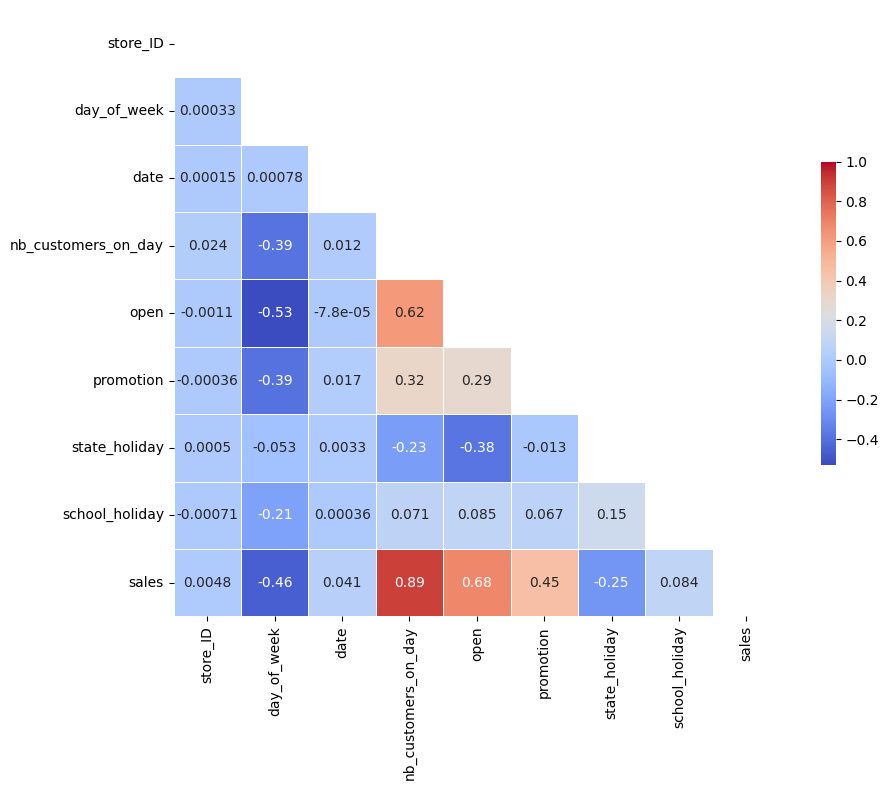

In [25]:
#Create a heatmap  to visualize which columns have high collinearity.

corr = stores.select_dtypes(include=['int64', 'float64']).corr()
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = 'coolwarm'

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, cmap=cmap, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#any columns have high collinearity.

In [27]:
#check if there is a case where the store is open but there is state holiday.
stores[(stores['state_holiday']==1) & (stores['open']==1)]

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
216,676,3,735234,946,1,0,1,1,5755
1529,582,1,735393,493,1,0,1,0,2146
1984,178,4,735018,962,1,1,1,0,10796
6382,780,4,735753,1060,1,1,1,0,8646
6465,178,4,735753,964,1,1,1,0,12155
...,...,...,...,...,...,...,...,...,...
637520,318,4,735403,755,1,1,1,0,8610
637629,95,4,735753,884,1,1,1,0,8317
638583,777,5,735509,190,1,1,1,0,1880
639009,1074,4,735018,679,1,1,1,0,6758


In [28]:
stores.dtypes

store_ID               int64
day_of_week            int64
date                   int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
dtype: object

# 3. Splitting the data


In [31]:
X = stores.drop(columns=['sales'])
y = stores['sales']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


# Decision Tree

In [33]:
# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train on baseline dataset
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

# Evaluate the baseline model
baseline_mse = mean_squared_error(y_test, y_pred)
baseline_r2 = r2_score(y_test, y_pred)

print(f"Baseline Model - MSE: {baseline_mse}, R^2: {baseline_r2}")


Baseline Model - MSE: 1442720.6049872043, R^2: 0.9023979393646306


In [34]:
# Create a filtered dataframe for stores when open:

stores_open = stores[stores['open'] == 1]

In [37]:
X_open = stores_open.drop(columns=['sales'])
y_open= stores_open['sales']

In [38]:
# Split the baseline dataset
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(X_open, y_open, test_size=0.2, random_state=42)


In [39]:
# Initialize the Decision Tree Regressor
dt_regressor_open = DecisionTreeRegressor(random_state=42)

# Train on baseline dataset
dt_regressor_open.fit(X_train_open, y_train_open)
y_pred_open = dt_regressor_open.predict(X_test_open)

# Evaluate the baseline model
mse_open = mean_squared_error(y_test_open, y_pred_open)
r2_open = r2_score(y_test_open, y_pred_open)

print(f"Baseline Model - MSE: {mse_open}, R^2: {r2_open}")


Baseline Model - MSE: 1768388.5587008006, R^2: 0.8160326897674801


#### - Finding the Optimal Tree Depth

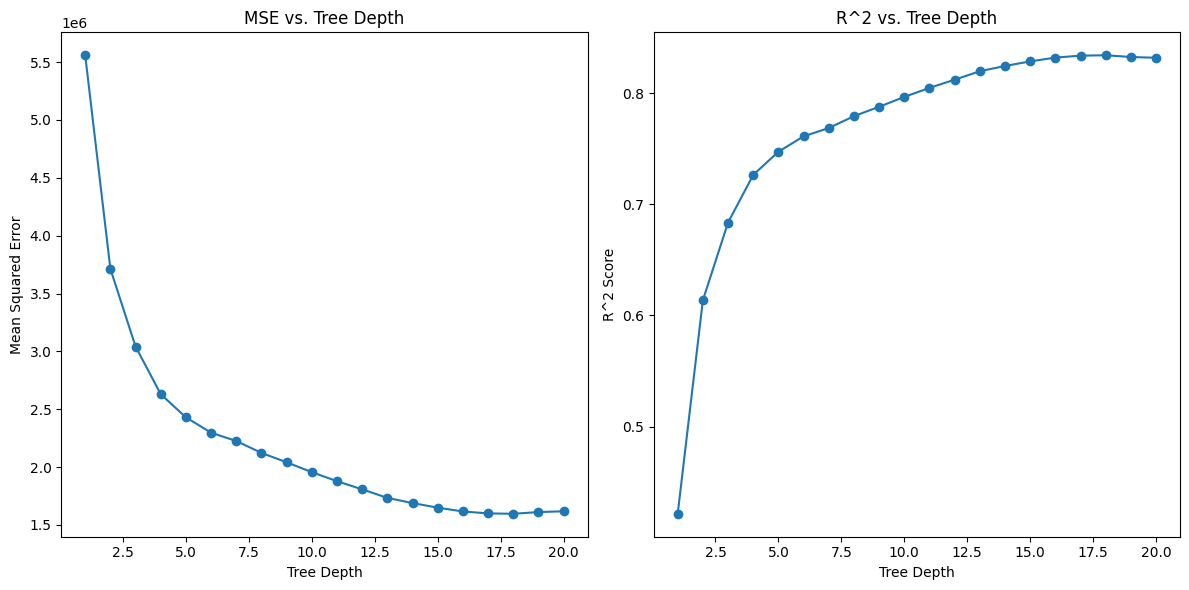

Optimal tree depth: 18


In [41]:
# Lists to store performance metrics
depths = range(1, 21)  # Testing tree depths from 1 to 20
mse_values = []
r2_values = []

for depth in depths:
    # Initialize the Decision Tree Regressor with the current depth
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Train the model
    dt_regressor.fit(X_train_open, y_train_open)
    
    # Predict on the test set
    y_pred = dt_regressor.predict(X_test_open)
    
    # Calculate MSE and R^2
    mse = mean_squared_error(y_test_open, y_pred)
    r2 = r2_score(y_test_open, y_pred)
    
    # Store the results
    mse_values.append(mse)
    r2_values.append(r2)

# Plotting the results to find the optimal depth visually
plt.figure(figsize=(12, 6))

# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(depths, mse_values, marker='o')
plt.title('MSE vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')

# Plot R^2 values
plt.subplot(1, 2, 2)
plt.plot(depths, r2_values, marker='o')
plt.title('R^2 vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('R^2 Score')

plt.tight_layout()
plt.show()

# Find the depth with the minimum MSE
optimal_depth = depths[mse_values.index(min(mse_values))]
print(f"Optimal tree depth: {optimal_depth}")

In [43]:
# optimal estimators

# Define a smaller set of n_estimators values to test
n_estimators_values = [ 100,  200]

# Lists to store performance metrics
mse_values = []
r2_values = []

for n in n_estimators_values:
    # Initialize the Random Forest Regressor with the current n_estimators and optimal depth
    rf_model = RandomForestRegressor(n_estimators=n, max_depth=optimal_depth, random_state=42)
    
    # Train the model
    rf_model.fit(X_train_open, y_train_open)
    
    # Predict on the test set
    y_pred_rf = rf_model.predict(X_test_open)
    
    # Calculate MSE and R^2
    mse = mean_squared_error(y_test_open, y_pred_rf)
    r2 = r2_score(y_test_open, y_pred_rf)
    
    # Store the results
    mse_values.append(mse)
    r2_values.append(r2)

# Plotting the results to find the optimal n_estimators visually
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, mse_values, marker='o')
plt.title('MSE vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.show()

# Find the optimal number of estimators based on the lowest MSE
optimal_n_estimators = n_estimators_values[mse_values.index(min(mse_values))]
print(f"Optimal number of estimators: {optimal_n_estimators}")

KeyboardInterrupt: 

## Random Forest

In [46]:
# Train the final Random Forest model with the optimal depth and number of estimators
rf_model_optimal = RandomForestRegressor(n_estimators=200, max_depth=optimal_depth, random_state=42)
rf_model_optimal.fit(X_train_open, y_train_open)
y_pred_rf_optimal = rf_model_optimal.predict(X_test_open)

# Evaluate the optimized Random Forest model
rf_optimal_mse = mean_squared_error(y_test_open, y_pred_rf_optimal)
rf_optimal_r2 = r2_score(y_test_open, y_pred_rf_optimal)

print(f"Optimized Random Forest Model - MSE: {rf_optimal_mse}, R^2: {rf_optimal_r2}")

Optimized Random Forest Model - MSE: 1143425.4131805939, R^2: 0.881048259060846


## Gradient Boost

In [49]:
# Initialize the Gradient Boosting Regressor with the optimal parameters
gboost_model = GradientBoostingRegressor(n_estimators=200, max_depth=optimal_depth, random_state=42)
gboost_model.fit(X_train_open, y_train_open)

# Predict on the test set
y_pred_gboost = gboost_model.predict(X_test_open)

# Evaluate the Gradient Boosting model
gboost_mse = mean_squared_error(y_test_open, y_pred_gboost)
gboost_r2 = r2_score(y_test_open, y_pred_gboost)

print(f"Gradient Boosting Model - MSE: {gboost_mse}, R^2: {gboost_r2}")

Gradient Boosting Model - MSE: 539338.0137793832, R^2: 0.9438921026643385


## XGBoost

In [50]:
# Initialize the XGBoost Regressor with the optimal parameters
xgboost_model = xgb.XGBRegressor(n_estimators=200, max_depth=optimal_depth, random_state=42)
xgboost_model.fit(X_train_open, y_train_open)

# Predict on the test set
y_pred_xgboost = xgboost_model.predict(X_test_open)

# Evaluate the XGBoost model
xgboost_mse = mean_squared_error(y_test_open, y_pred_xgboost)
xgboost_r2 = r2_score(y_test_open, y_pred_xgboost)

print(f"XGBoost Model - MSE: {xgboost_mse}, R^2: {xgboost_r2}")

XGBoost Model - MSE: 1235073.5561927594, R^2: 0.8715140223503113
